# Basic characterizations of LA Q2
### using Experiment and Analysis classes

In [68]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 5 # for LA Q2
res_index = 5 # for LA Q2
flux_index = 5 # for LA Q2
TLS_index = 0 # for TLS of interest

In [69]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [70]:
# Set all DC bias to 0
for i in np.arange(7):
    val = machine.flux_lines[i].dc_voltage       
    machine.flux_lines[i].dc_voltage -= val
machine = Analysis.set_machine(machine)

In [71]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [72]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [139]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-03-20 16:14:04,526 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 16:14:04,537 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r5 for (LO, IF) = (6.170 GHz, -50.000 MHz)
2024-03-20 16:14:12,779 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q5 for (LO, IF) = (5.586 GHz, -50.000 MHz)
2024-03-20 16:15:06,200 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Time of flight

DC offset to add to I: -0.000056 V
DC offset to add to Q: 0.000198 V
TOF to add: 0.0 ns


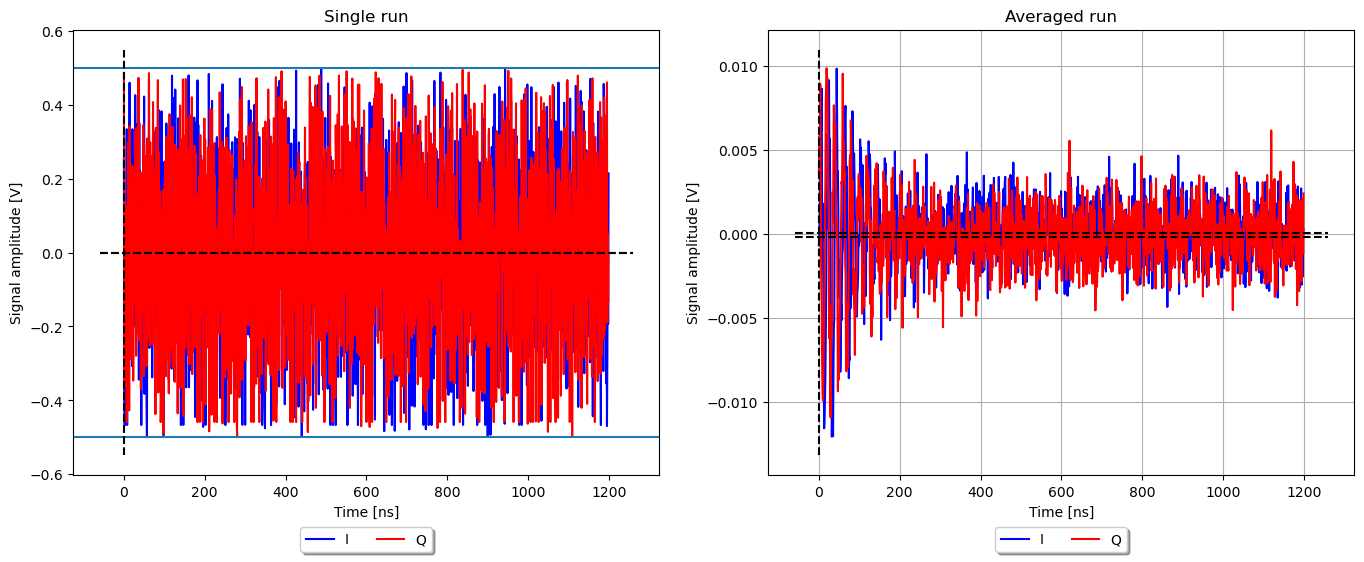

In [148]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 10E3, cd_time = 10E3, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [149]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += dc_offset_i.item()
machine.global_parameters.con1_downconversion_offset_Q += dc_offset_q.item()
#machine.global_parameters.time_of_flight = 304-0
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [87]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                            n_avg = 1E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)
# Readout in excited state
# machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
#                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.17s


resonator frequency: 6119.885 MHz
Execution stopped by user!


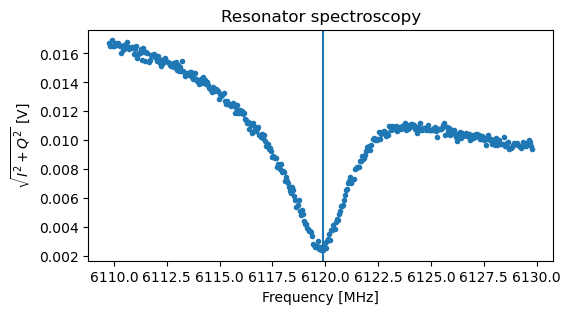

In [88]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine.resonators[res_index].lo = res_freq.tolist() + 50E6
machine = Analysis.set_machine(machine)

In [89]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-03-20 15:26:58,375 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 15:26:58,385 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r5 for (LO, IF) = (6.170 GHz, -50.000 MHz)
2024-03-20 15:27:06,816 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q5 for (LO, IF) = (5.585 GHz, -50.000 MHz)
2024-03-20 15:27:19,229 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## 2D RO resonator spectroscopy vs DC flux

Progress: [##################################################] 100.0% (n=37/37)


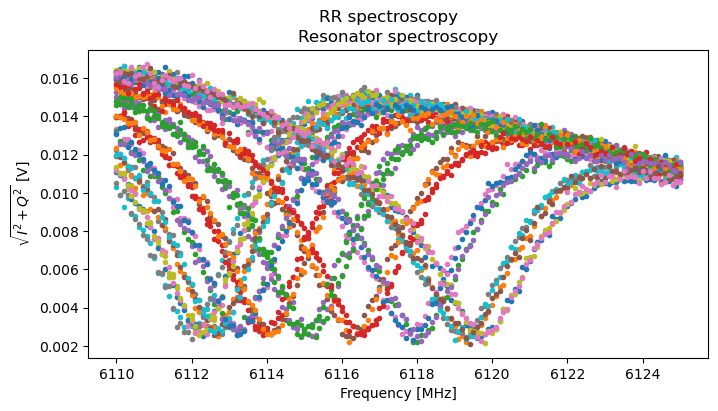

In [90]:
res_freq_sweep = np.arange(6.110E9,6.125E9 + 1.0,0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib inline
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, 
                            n_avg = 1E3, cd_time = 10E3)

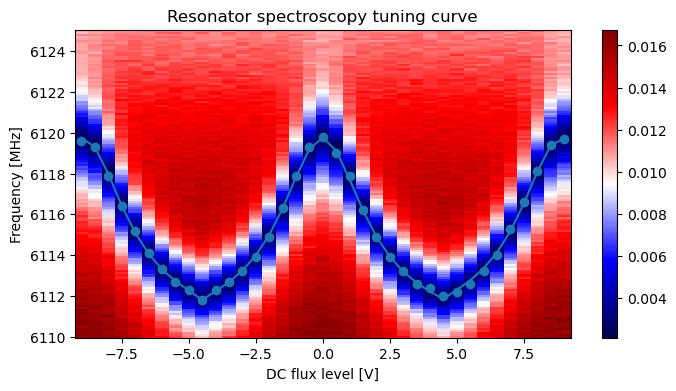

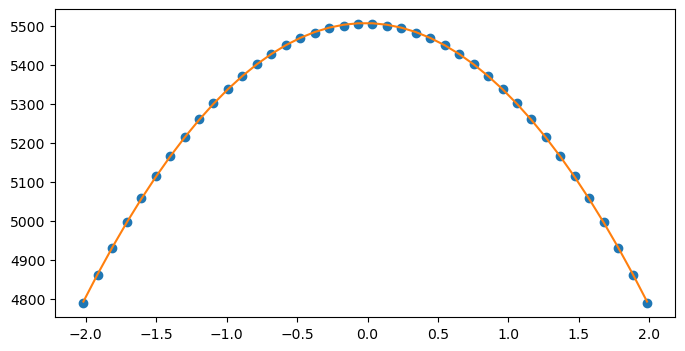

In [91]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = [6122, 170, 30E3, 0.05, 0.4, 70])
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [92]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [93]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].DC_tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [94]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.70s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.75s
resonator frequency: 6119.707 MHz


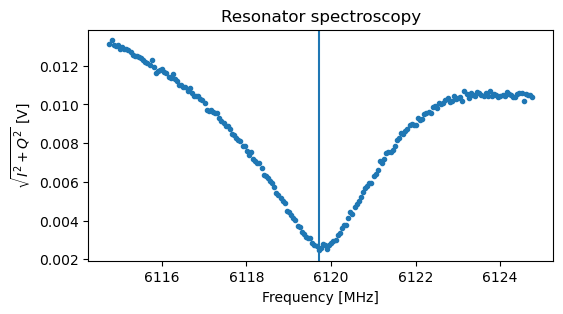

In [95]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 5E3, cd_time = 5E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [29]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

2024-03-12 15:37:41,785 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-12 15:37:41,795 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r5 for (LO, IF) = (6.170 GHz, -50.000 MHz)
2024-03-12 15:37:48,983 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q5 for (LO, IF) = (5.576 GHz, -50.000 MHz)
2024-03-12 15:38:02,168 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [208]:
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag=True)

2024-03-21 07:19:27,392 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 07:19:27,403 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r5 for (LO, IF) = (6.170 GHz, -50.000 MHz)
2024-03-21 07:19:35,305 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q5 for (LO, IF) = (5.586 GHz, -50.000 MHz)
2024-03-21 07:19:48,632 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [127]:
if True: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz
    
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-150E6, 250E6 + 1, 1E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1, ff_amp = 0.0, n_avg = 5E3, cd_time = 20E3, plot_flag = False, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 43.55s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 43.60s


resonant frequency: 5536.145 MHz


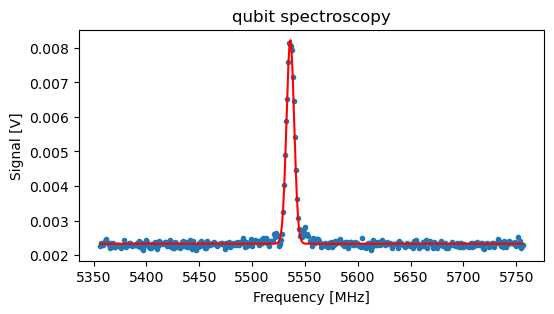

In [128]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].f_tls[0] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine = Analysis.set_machine(machine)

In [129]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

2024-03-20 16:07:13,877 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 16:07:14,045 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r5 for (LO, IF) = (6.170 GHz, -50.000 MHz)
2024-03-20 16:07:21,793 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q5 for (LO, IF) = (5.586 GHz, -50.000 MHz)
2024-03-20 16:07:35,526 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Rabi

### time rabi

In [169]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 50 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 25E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 12.38s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 12.43s


rabi_pi_pulse: 103.2 ns
half period: 100.36 ns


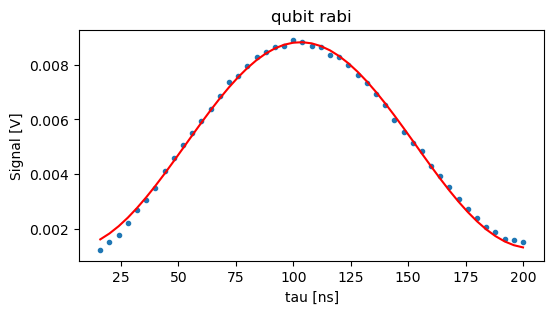

In [170]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [157]:
machine.qubits[qubit_index].pi_length[0] = 120
#machine.qubits[qubit_index].pi_amp[0] = 0.02
machine = Analysis.set_machine(machine)

### power rabi

In [171]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.1, 2, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 10E3, cd_time = 40E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 15.75s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 15.79s


rabi_pi_pulse_amp: 0.11215 V
half period: 0.1093414 V


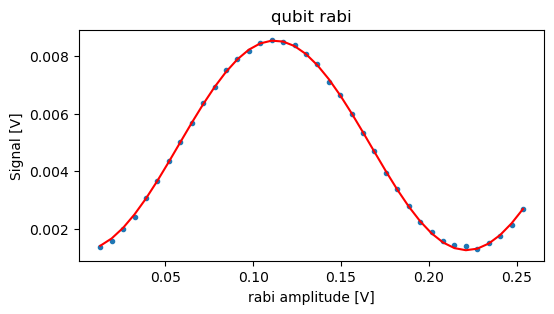

In [172]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [168]:
machine.qubits[qubit_index].pi_amp[0] = 0.13
machine = Analysis.set_machine(machine)

In [165]:
machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.item()
machine = Analysis.set_machine(machine)

## T1

In [173]:
%matplotlib qt
tau_sweep_abs = np.arange(100,20E3+1,500)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 5E3, cd_time = 30E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 8.13s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 8.18s


Qubit T1 [us]: 2.7354559603776223


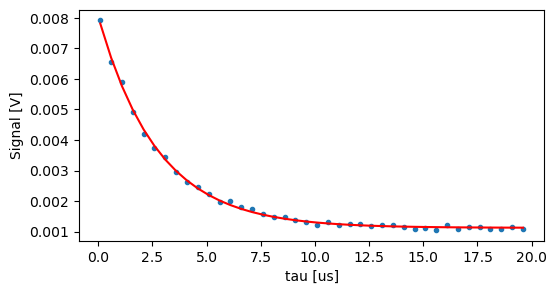

In [174]:
%matplotlib inline
q_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey

In [175]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 1200 + 0.1, 5)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_amp = Experiment.exp1D.Ramsey.ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, 
          n_avg = 10E3, detuning = 2E6, cd_time = 20E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 57.10s


Qubit T2* [ns]: 2237.3037675402643
Detuning [MHz]: 2.034963761567747
Exponent n: 0.8793083407484903


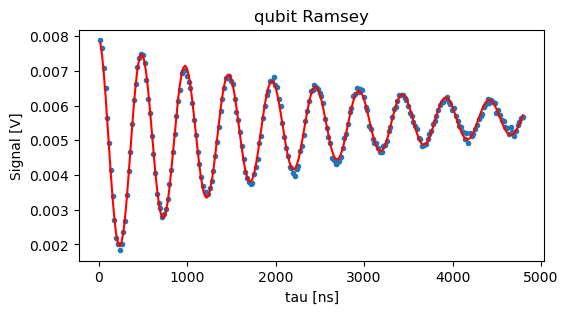

In [177]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_amp,plot_flag = True)
machine.qubits[qubit_index].T2 = int(q_T2star.tolist())
machine = Analysis.set_machine(machine)

## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-200E6, -150E6 + 1, 0.5E6) 
machine, ef_freq_sweep, sig_amp = Experiment.exp1D.Rabi.ef_freq(ef_freq_sweep, qubit_index, res_index, flux_index, 
                      pi_amp_rel = 1, pi_amp_rel_ef = 1.0, n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, 
                      simulate_flag = False, simulation_len = 4000)

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(x=ef_freq_sweep,y=sig_amp,method="gaussian")

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - int(ef_freq)
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_length[1] = 80
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 3.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.ef_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine,
                          simulate_flag = False, simulation_len = 1000)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_amp[1] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs dc flux

In [182]:
machine = Analysis.get_machine()

In [183]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.5,0.5+1E-4,0.02)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

Progress: [##################################################] 100.0% (n=51/51) --> elapsed time: 723.39s


In [184]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

sweet spot flux: -0.01030 V


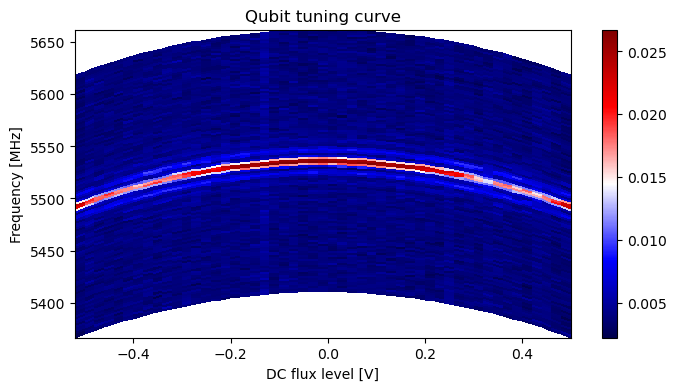

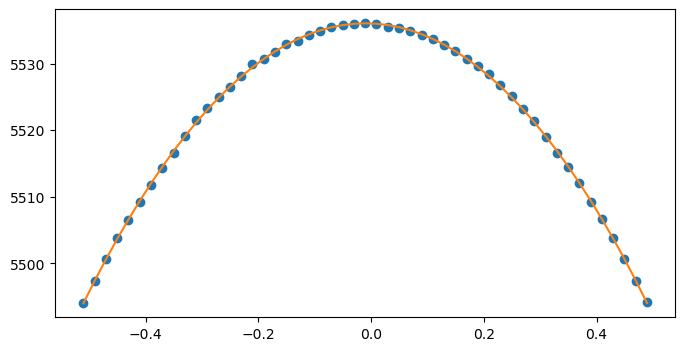

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
E

In [185]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [187]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [188]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2024-03-20 17:34:30,306 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 17:34:30,316 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


In [195]:
# try the experiment
%matplotlib qt
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.25+1E-4,0.05)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)
if False: # first time running this, no AC_tuning_curve
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = 5, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)
else: # after the first run 
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

2024-03-20 17:53:37,522 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 17:53:37,532 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q5 for (LO, IF) = (5.243 GHz, 290.000 MHz)
2024-03-20 17:53:43,070 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-03-20 17:54:27,069 - qm - INFO     - Performing health check.3% (n=5/6) --> elapsed time: 49.52s


INFO:qm.api.frontend_api:Performing health check


2024-03-20 17:54:27,080 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q5 for (LO, IF) = (4.982 GHz, 290.000 MHz)
2024-03-20 17:54:32,565 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=6/6) --> elapsed time: 79.32s
2024-03-20 17:54:56,857 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 17:54:56,866 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q5 for (LO, IF) = (4.796 GHz, 290.000 MHz)
2024-03-20 17:55:02,506 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


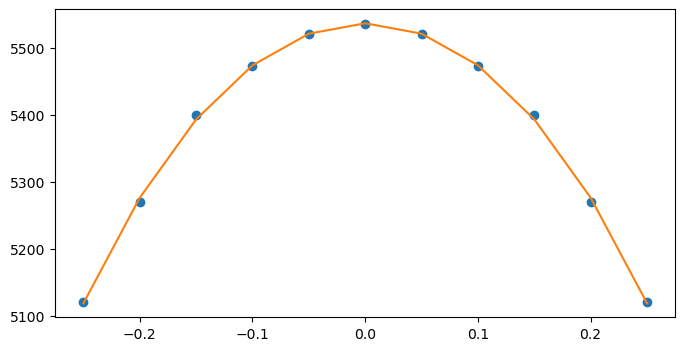

In [196]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [203]:
machine = Analysis.get_machine()

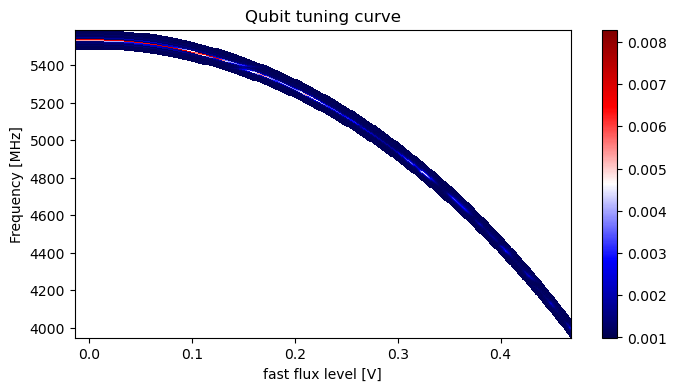

In [207]:
# data = loadmat(r'Z:\LabberData_DF5\QM_Data_DF5\2024\03\Data_0312\Q6-qubit_freq_vs_fast_flux-0312-1652.mat')
# qubit_freq_sweep = data['Q_freq']
# sig_amp_qubit = data['sig_amp_qubit']
# ff_sweep_abs = data['fast_flux_sweep'][0]
%matplotlib inline
fig = plt.figure()
plt.rcParams['figure.figsize'] = [8, 4]
plt.pcolormesh(ff_sweep_abs, (qubit_freq_sweep/u.MHz).T, sig_amp_qubit.T, cmap="seismic")
plt.title("Qubit tuning curve")
plt.xlabel("fast flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()



In [204]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4E9, -5E6)
# qubit_freq_sweep = np.arange(q_freq_max,4E9,-100E6)
qubit_if_sweep = np.arange(-50E6, 50E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 20E3, cd_time = 25E3, plot_flag = True)

2024-03-20 18:26:22,115 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 18:26:22,129 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q5 for (LO, IF) = (5.235 GHz, 200.000 MHz)
2024-03-20 18:26:27,804 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4309.95s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4310.11s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4309.99s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4310.14s
2024-03-20 20:50:34,361 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 20:50:34,377 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q5 for (LO, IF) = (5.035 GHz, 200.000 MHz)
2024-03-20 20:50:39,717 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4309.93s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4310.09s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4309.77s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4309.92s
2024-03-20 23:14:46,554 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 23:14:46,569 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q5 for (LO, IF) = (4.435 GHz, 200.000 MHz)
2024-03-20 23:14:52,142 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4309.94s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4310.10s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4309.91s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4310.08s
2024-03-21 01:38:58,481 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 01:38:58,495 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q5 for (LO, IF) = (4.235 GHz, 200.000 MHz)
2024-03-21 01:39:03,841 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4309.99s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 4310.14s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 3016.98s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 3017.12s
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


<Figure size 800x400 with 0 Axes>

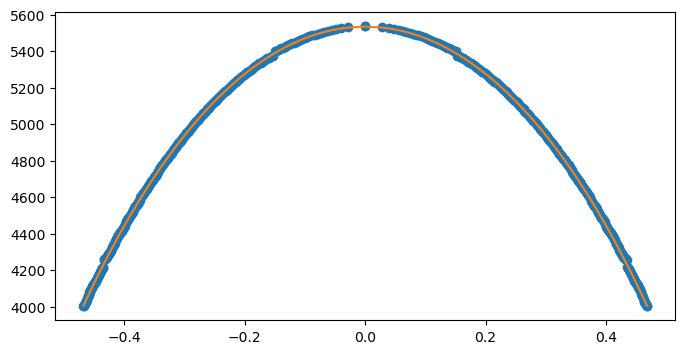

In [205]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
#machine.qubits[qubit_index].AC_tuning_curve = [-4245.549395948013,0.0,-6707.594982241495,0.0,6413.009439410573]
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

# TLS experiments

## TLS SWAP spectroscopy

In [209]:
machine = Analysis.get_machine()
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True, machine = machine)

2024-03-21 07:20:07,332 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 07:20:07,355 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r5 for (LO, IF) = (6.170 GHz, -50.000 MHz)
2024-03-21 07:20:14,573 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q5 for (LO, IF) = (5.586 GHz, -50.000 MHz)
2024-03-21 07:20:27,883 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


### coarse, no baking

In [210]:
%matplotlib qt
tau_sweep_abs = np.arange(16,160 + 0.1,4)
ff_sweep_abs = np.arange(0.1,0.5,0.0005)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 5E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3228.80s
Execution stopped by user!


### fine, with baking

In [48]:
%matplotlib qt
tau_sweep_abs = np.arange(4,100,1)
ff_sweep_abs = np.arange(0.418,0.43+1E-4,0.0005)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 5E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 488.31s
Execution stopped by user!


In [49]:
machine.flux_lines[flux_index].iswap.length.append(30)
machine.flux_lines[flux_index].iswap.level.append(0.4265)
machine = Analysis.set_machine(machine)

### estiguess of the TLS freq., based on SWAP flux

In [50]:
machine = Analysis.get_machine()

In [51]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
for f_tmp in freq_tls:
    machine.qubits[qubit_index].f_tls.append(np.floor(f_tmp*1E6))
machine = Analysis.set_machine(machine)

## TLS T1

In [52]:
print(freq_tls)

[4741.62811162 4741.62811162 4286.23685359]


In [53]:
TLS_index = 1

In [59]:
%matplotlib qt
tau_sweep_abs = np.arange(100,30E3+1,1E3)

#tau_sweep_abs = np.logspace(100,2000E3,50,endpoint=True)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 10E3, cd_time_qubit = 25E3, cd_time_TLS =80E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Execution stopped by user!                                   ] 31.8% (n=3179/10000.0) --> elapsed time: 13.79s


Qubit T1 [us]: 2.6643320150454186


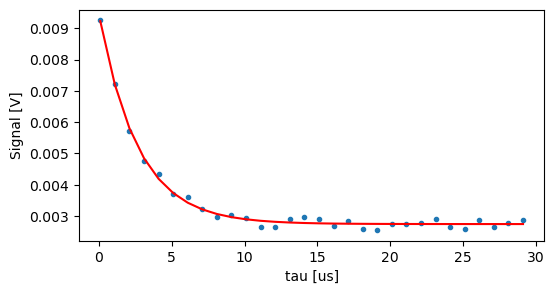

In [61]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

## TLS drive

### TLS spectroscopy

In [178]:
TLS_index = 1

In [199]:
machine.qubits[qubit_index].f_01

4741758117.0

In [197]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level[TLS_index])
TLS_freq_est = np.round(TLS_freq_est * 1E6)
machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist()))
machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

In [198]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] + 0E6
machine = Analysis.set_machine(machine)

In [200]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-02-12 09:49:15,193 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-12 09:49:15,204 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r5 for (LO, IF) = (6.171 GHz, -50.000 MHz)
2024-02-12 09:49:23,154 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q5 for (LO, IF) = (4.542 GHz, 200.000 MHz)
2024-02-12 09:49:35,298 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [201]:
%matplotlib qt
TLS_freq_sweep = TLS_freq_est + np.arange(-60E6,100E6+1,1.0E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1, n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 4000E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3236.17s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3236.24s


resonant frequency: 4781.174 MHz


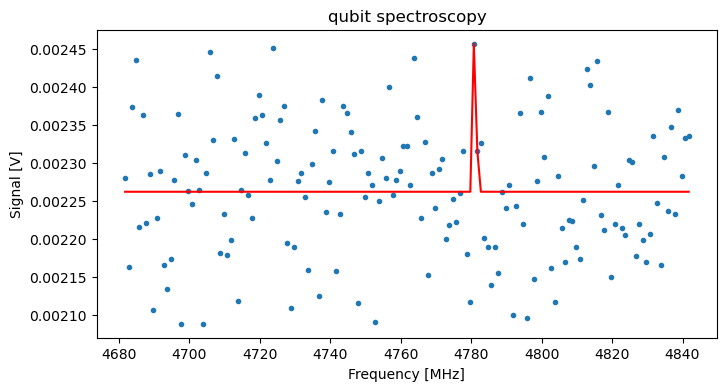

In [203]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
# qubit_freq = int(qubit_freq.tolist())
# machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
# machine.qubits[qubit_index].lo = qubit_freq - 200E6
# machine = Analysis.set_machine(machine)

### TLS rabi

In [ ]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1]

In [191]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 300 + 0.1, 4)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 2.0, n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 30.89s
Execution stopped by user!
Execution stopped by user!
